In [5]:
!pip install tensorflow keras matplotlib seaborn opencv-python scikit-learn


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
dataset_path = '/content/drive/MyDrive/Defense/Leveled_dataSet'
save_folder = '/content/drive/MyDrive/Defense/Saved_Models'
os.makedirs(save_folder, exist_ok=True)

In [9]:
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2     # 80% train | 20% test
)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

test_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 4800 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.


In [10]:
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(img_size, img_size, 3)
)

base_model.trainable = False   # freeze base layers first

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [11]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2363s 16s/step - accuracy: 0.2572 - loss: 2.0529 - val_accuracy: 0.7525 - val_loss: 1.0047
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.6125 - loss: 1.0745 - val_accuracy: 0.8700 - val_loss: 0.6113
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 310ms/step - accuracy: 0.7933 - loss: 0.6613 - val_accuracy: 0.8967 - val_loss: 0.4424
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 307ms/step - accuracy: 0.8535 - loss: 0.4961 - val_accuracy: 0.9008 - val_loss: 0.3534
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 308ms/step - accuracy: 0.8946 - loss: 0.3762 - val_accuracy: 0.9058 - val_loss: 0.2998
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 313ms/step - accuracy: 0.9114 - loss: 0.3060 - val_accuracy: 0.9183 - val_loss: 0.2634
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 310ms/step - accuracy: 0.9136 - loss: 0.2817 - val_accuracy: 0.9225 - val_loss: 0.2373
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 304ms/step - accuracy: 0.9362 - loss: 0

In [12]:
model_path = os.path.join(save_folder, "densenet121_coconut.h5")
model.save(model_path)

print("Model saved at:", model_path)


Model saved at: /content/drive/MyDrive/Defense/Saved_Models/densenet121_coconut.h5


In [13]:
loss, acc = model.evaluate(test_data)
print("Test Accuracy:", acc)
print("Test Loss:", loss)


38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.9668 - loss: 0.0991
Test Accuracy: 0.9541666507720947
Test Loss: 0.12810958921909332


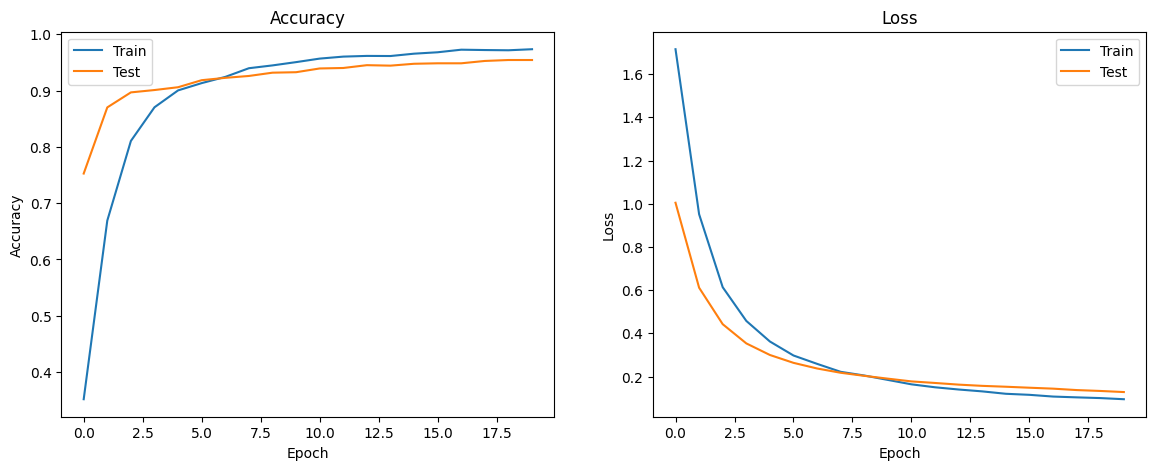

In [14]:
plt.figure(figsize=(14,5))

# accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"])

# loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"])

plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 533ms/step


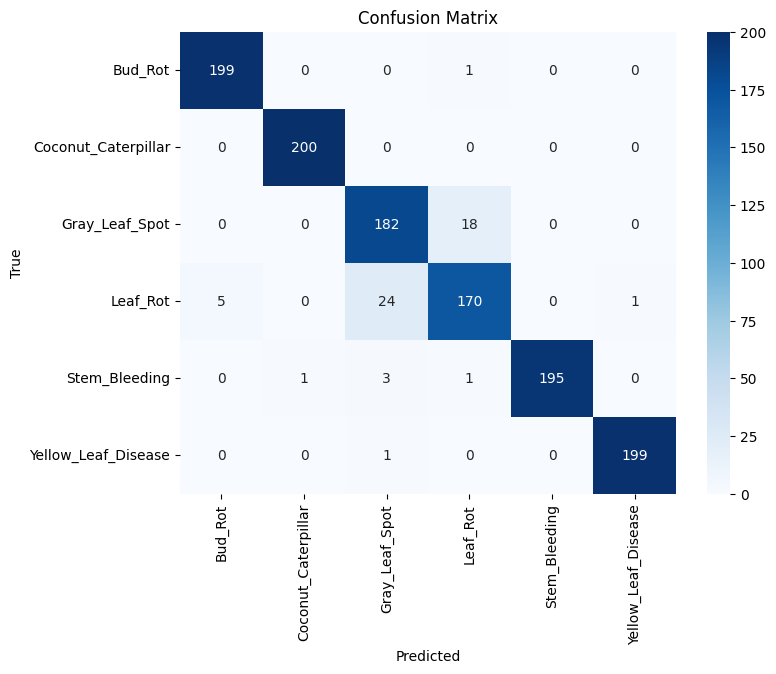

                     precision    recall  f1-score   support

            Bud_Rot       0.98      0.99      0.99       200
Coconut_Caterpillar       1.00      1.00      1.00       200
     Gray_Leaf_Spot       0.87      0.91      0.89       200
           Leaf_Rot       0.89      0.85      0.87       200
      Stem_Bleeding       1.00      0.97      0.99       200
Yellow_Leaf_Disease       0.99      0.99      0.99       200

           accuracy                           0.95      1200
          macro avg       0.95      0.95      0.95      1200
       weighted avg       0.95      0.95      0.95      1200



In [15]:
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

labels = list(train_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))


In [11]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Defense/Saved_Models/densenet121_coconut.h5')

In [12]:
def grad_cam(model, img_path, layer_name="conv5_block16_concat"):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (img_size, img_size))
    img_array = img_resized.astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    grad_model = tf.keras.models.Model(
        [model.input],
        [
            model.get_layer(layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        pred_output = preds[:, pred_index]

    grads = tape.gradient(pred_output, conv_out)[0]
    conv_out = conv_out[0]

    weights = np.mean(grads, axis=(0, 1))
    heatmap = np.dot(conv_out, weights)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-9)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return overlay, heatmap


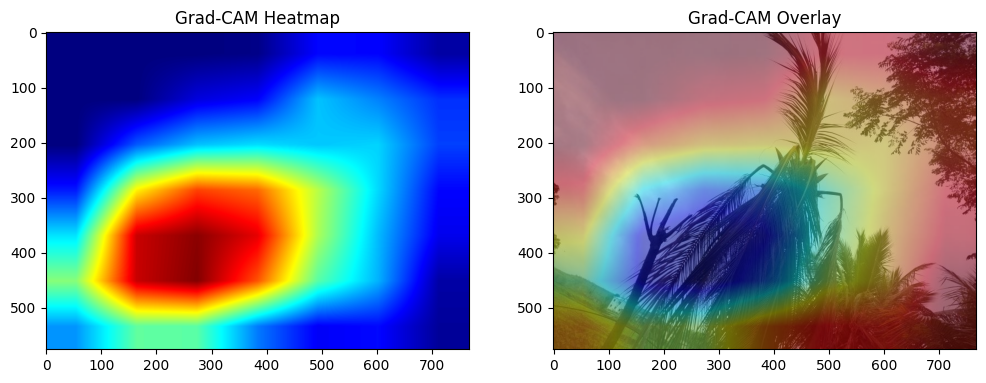

In [17]:
image_path = dataset_path + "/Bud_Rot/BudRootDropping281.jpg"

overlay, heatmap = grad_cam(model, image_path)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(heatmap[..., ::-1])
plt.title("Grad-CAM Heatmap")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 282s 7s/step


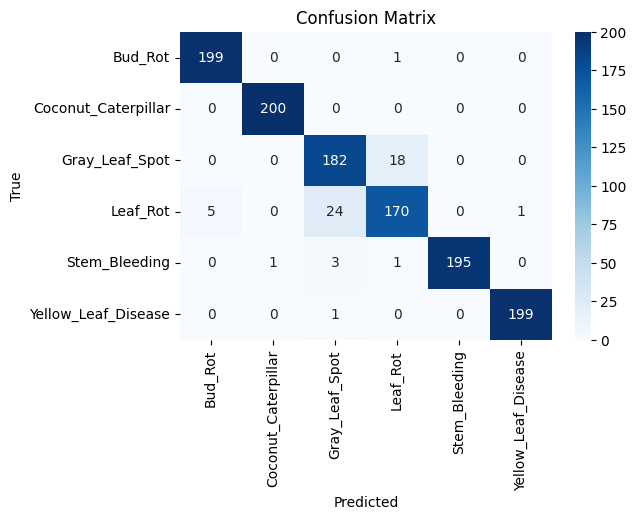

                     precision    recall  f1-score   support

            Bud_Rot       0.98      0.99      0.99       200
Coconut_Caterpillar       1.00      1.00      1.00       200
     Gray_Leaf_Spot       0.87      0.91      0.89       200
           Leaf_Rot       0.89      0.85      0.87       200
      Stem_Bleeding       1.00      0.97      0.99       200
Yellow_Leaf_Disease       0.99      0.99      0.99       200

           accuracy                           0.95      1200
          macro avg       0.95      0.95      0.95      1200
       weighted avg       0.95      0.95      0.95      1200



In [19]:
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

labels = list(train_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))